# Thinking Non-Linearly about the Effective AoA of a FWTD

Within all the current linear analysis of FWTD's the following equation has been used to describe the change in AoA of the FWT with respect to the flare and fold angle:

$\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$)

where $\theta$ is the fold angle and $\Lambda$ is the flare angle

This is derived using small angle approximations. By considering this equation at some critical locations we can highlight some of the shortcomings of the equation

### Fold Angle of 90 Degrees

$\Delta\alpha_h(\Lambda)\rvert_{\theta = \frac{\pi}{2}} = \infty$

This is obviously incorrect, and from inspection of the geomtry it is clear that if $\Lambda = 0 \to \Delta\alpha = 0 $ and $\Lambda \lt 0 \to \Delta\alpha < 0$

### Flare Angle of 0 Degrees

$\Delta\alpha_h(\theta)\rvert_{\Lambda = 0} = 0$

Or more over the AoA of the FWT is not a function of theta if there is no flare angle.

This again can be disproven by considering a wing at the initial conditions:

$\alpha = \alpha_r, \Lambda = \theta = 0$

In this condition the AoA of the FWT must be the AoA of the main wing, $\alpha_r$. However, when you then rotate theta up to $\pm\frac{\pi}{2}$ the AoA of the FWT tends to ZERO! 

$\theta = \pm\frac{\pi}{2}, \Lambda = 0, \alpha_h = 0 $

i.e. $\Delta\alpha_h$ is a function of $\alpha_r$ & $\theta$ even if $\Lambda = 0$

# So What is the Equation for $\Delta\alpha_h$ ?

What is clear is that $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta)$

To find what this function is we will use rotation matrices to go from the 'Velocity Frame of Reference' to the 'Hinge Frame of Reference'. For completeness we will also consider the effect of yawslip, e.g. $\gamma$. Hence $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta, \gamma)$

In the Velocity frame of reference the velocity vector is:

$\mathbf{V} = \begin{bmatrix}u\\0\\0\end{bmatrix}$ 

where $u$ is the velocity magnitude. The aim is to translate this vector into the 'hinge reference frame' in which
1. $y$ runs along the leading edge of the FWT
2. $x$ runs along the chord line of the FWT

### Preamble

In [1]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## a/c to wind transform
alpha,beta = sym.symbols(['alpha','beta'])
V_Ac = sym.rot_axis2(-alpha)*sym.rot_axis3(-beta)  # transform from a/c to the velocity frame 
Ac_V = V_Ac**-1                                    # transform from velocity frame to a/c


## a/c to Hinge transform
Lambda,theta = sym.symbols(['Lambda','theta'])


H_Ac = sym.trigsimp(sym.rot_axis3(-Lambda)*\
                    sym.rot_axis1(theta)*  \
                    sym.rot_axis3(Lambda))        # transform from a/c to the hinge frame 


H_V = sym.trigsimp(H_Ac*Ac_V)                      # transform from velocity to hinge reference frame

# Velocity vector in velocity frame is of the form [v 0 0]
u = sym.Symbol('u')
Vv = sym.Matrix([u,0,0])

# Transform into the hinge reference frame
Vh = H_V * Vv

f = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)
Vh

Matrix([
[           u*(-sin(Lambda)*sin(alpha)*sin(theta) + sin(Lambda)*sin(Lambda + beta)*cos(alpha)*cos(theta) - sin(Lambda)*sin(Lambda + beta)*cos(alpha) + cos(alpha)*cos(beta))],
[u*(-sin(Lambda)*cos(alpha)*cos(theta)*cos(Lambda + beta) + sin(Lambda)*cos(alpha)*cos(Lambda + beta) + sin(alpha)*sin(theta)*cos(Lambda) - sin(beta)*cos(alpha)*cos(theta))],
[                                                                                                       u*(sin(alpha)*cos(theta) + sin(theta)*sin(Lambda + beta)*cos(alpha))]])

 The above is the velocity vector in the hinge reference frame. It is quite complex compared to the relative simplicity of the one above, so lets explore it a little bit That is quite complex. Lets explore this vector a little bit....

Note, if we call the above vector $V^h$ and its components $v_N^h,for N=0,1,2$ then the change in $\alpha,\beta$ and $u$ are:

$\Delta\alpha_h = \arctan{\frac{v_2^h}{v_0^h}}-\alpha$

$\Delta\beta_h = \arctan{\frac{v_1^h}{v_0^h}}-\beta$

and importantly the effective velocity changes as well (call $u_h$ the magnitude of the flow perp to the FWT's LE):

$u_h = \sqrt{(v_0^h)^2+(v_2^h)^2}$

This is assuming the cross flow has a negligable effect on the aerodynamics...

Below I am going to calculate this velocity vector for multiple instances of each of the variables, we will then explore the parameter space.

In [3]:
AoAs = np.linspace(-10,10,9)
Thetas = np.linspace(-135,135,55)
Lambdas = np.linspace(-25,25,11)
Betas = np.linspace(-25,25,11)

dat = []

for i in AoAs:
    for j in Thetas:
        for k in Lambdas:
            for w in Betas:
                dat.append([i,j,k,w,f(np.deg2rad(i),np.deg2rad(w),np.deg2rad(k),np.deg2rad(j),1).T])
df = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Beta','V'])
# print(df.head())
df[['v1','v2','v3']] = df['V'].apply(lambda x: pd.Series(x[0]) )
df['Alpha_h'] = np.rad2deg((df['v3']/df['v1']).apply(np.arctan))
df['DeltaAlpha_h'] = df['Alpha_h']-df['Alpha']
df['Beta_h'] = np.rad2deg((df['v2']/df['v1']).apply(np.arctan))
df['DeltaBeta_h'] = df['Beta_h']-df['Beta']
df['u_h'] = np.sqrt(df['v3']*df['v3'] + df['v1']*df['v1'])
# print(df.head())
# #df['Sweep_h'] = (df['v3']/df['v1']).apply(np.arctan)  
df = df.drop(labels='V',axis=1)

## Effect of AoA for $\Lambda = 0$

First lets plot some of the relationships decribed at the top to validate the formula.

When $\Lambda = 0$, for each AoA we should expect to see: 

$\alpha_h\rvert_{\theta = 90^o} = 0$

$\alpha_h\rvert_{\theta = 0^o} = \alpha$

which is exactly what you see below

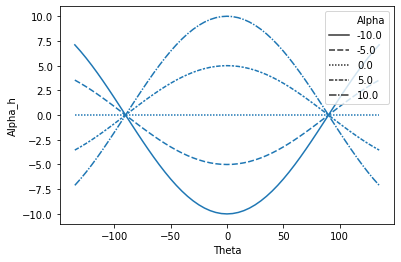

In [4]:
d = df[(pd.Series((np.isin(df['Alpha'],[10,5,0,-5,-10])))) & (df['Lambda']==0) & (df['Beta']==0)]

sns.lineplot(data = d,x='Theta',y='Alpha_h',style = 'Alpha')

## Effect of Lambda and Theta @ Alpha = 0

For $\alpha = 0$, varying $\theta$ should change the effect sweep of the FWT. In particular, from a geometric perspective:

$\Delta\beta\big\rvert_{\theta = \pi} = 2\Lambda$

In respect to $\Delta\alpha_h$, if the change in sweep had no effect, it should increase to a maximum of $\Lambda$ @ $\theta=\pi/2$ and then start to reduce. However how the change in swep will effect this is slightly unclear to me.  

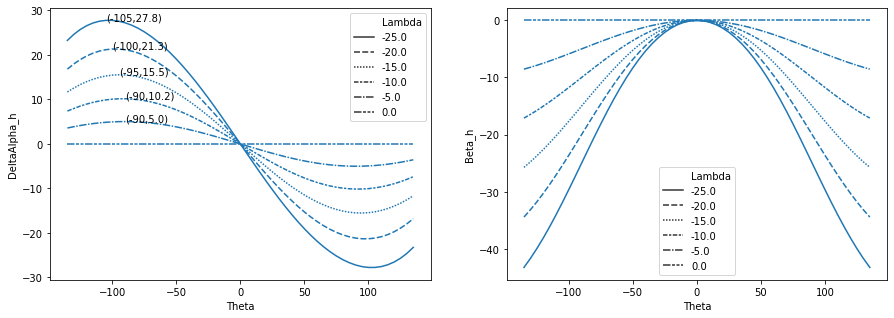

In [7]:
d = df[(pd.Series((np.isin(df['Lambda'],[-25,-20,-15,-10,-5,0])))) & (df['Alpha']==0) & (df['Beta']==0)]
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Lambda',ax=axes[0])
ax = sns.lineplot(data = d,x='Theta',y='Beta_h',style='Lambda',ax=axes[1])

# create a helper function for annotating the maximums
def AnnotateMaxs(data,group,x,y,ax):
    # annotate the maximum values on delat alpha plot
    maxVals = data[data[y] == data.groupby(group)[y].transform('max')]
    maxVals= maxVals[maxVals[y]>0]

    for index,row in maxVals.iterrows():
        yv = row[y]
        xv = row[x]
        ax.text(xv,yv,f'({xv:.0f},{yv:.1f})')
        
# annotate maximums
AnnotateMaxs(data=d,group='Lambda',x='Theta',y='DeltaAlpha_h',ax=axes[0])

The maximum alpha_h does not occur at 90 degrees, $\Lambda$ has the effect of delaying it, and also increasing its value.

However, this does not take in to account that the effective velocity has also reduced due to the increased sweep angle. The standard equation for the change in lift of the hinge is:

$\Delta L = \frac{1}{2}\rho u_h^2SC_L\Delta\alpha_h$ 

and assuming everything remains constant except for $\Delta\alpha_h$ & $V$, we can say:

$\Delta L \propto u_h^2\Delta\alpha_h$

Plotting this change for the same cases as above...

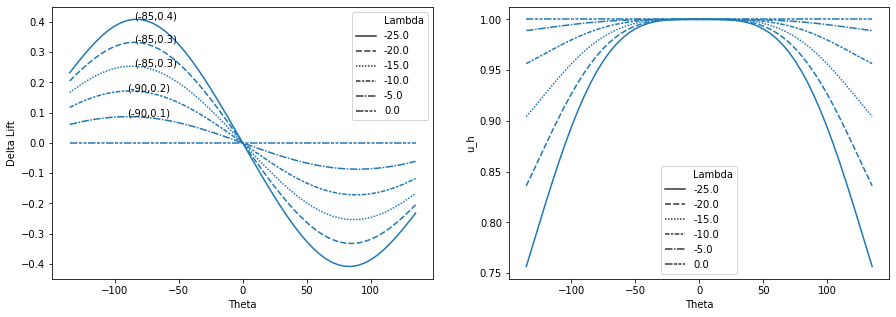

In [9]:
df['Delta Lift'] = df['u_h']*df['u_h']*np.deg2rad(df['DeltaAlpha_h'])

d = df[(pd.Series((np.isin(df['Lambda'],[-25,-20,-15,-10,-5,0])))) & (df['Alpha']==0) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='Delta Lift',style='Lambda',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='u_h',style='Lambda',ax=axes[1])


AnnotateMaxs(data=d,group='Lambda',x='Theta',y='Delta Lift',ax=axes[0])

The maximum moves closer to 0 degrees (rememeber the theta data was only claculated on 5 degrees increments atm)

## Take the Case of the WTT model ($\Lambda = -10^o$)

How does varying the AoA vary the plot above?

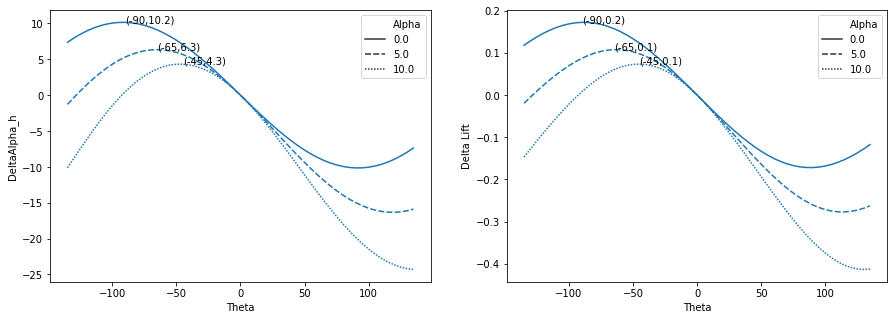

In [14]:
d = df[(pd.Series((np.isin(df['Alpha'],[0,5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='Delta Lift',style='Alpha',ax=axes[1])

AnnotateMaxs(data=d,group='Alpha',x='Theta',y='DeltaAlpha_h',ax=axes[0])
AnnotateMaxs(data=d,group='Alpha',x='Theta',y='Delta Lift',ax=axes[1])

At $AoA=10$ your maximum lift is achieved at ~-45 degrees and is a less than a 5 degrees variation on your starting angle.

at the start of each run the hinge hung well below 45 degree (closer to 60), wind ramp up, how would that play out for the AoA 10 case?

at the start just hanging, then as soon as it has enough lift to overcome its weight it will jump to the same C_l value on the other side of the hump?

In the WTT the maximum hinge angles achieved were $20 \to -30$ degrees, at 10 degrees AoA  how different are the predictions compared to that from the following equation?

$\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$)

[(-10, 10), (-10, 10)]

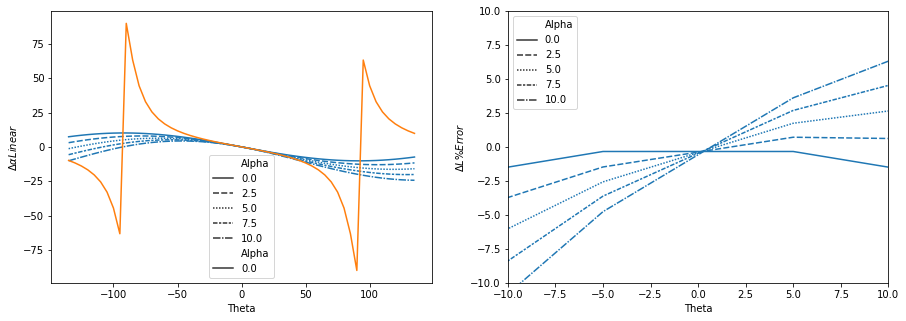

In [75]:
# add linear terms to the main pandas array

dAlphaLin = r'$\Delta\alpha Linear$'
dLiftLin = '$\Delta L Linear$'
dAlphaErrorS = '$\Delta\\alpha Error [Deg]$'
dLiftError = '$\Delta L \% Error$'

df[dAlphaLin] =np.rad2deg(np.arctan(np.tan(np.deg2rad(df['Theta']))*np.sin(np.deg2rad(df['Lambda']))))
df[dLiftLin] = np.deg2rad(df[dAlphaLin])
df[dAlphaErrorS] = df['DeltaAlpha_h']-df[dAlphaLin]
df[dLiftError] = (np.round(df['Delta Lift'],5)-df[dLiftLin])/np.round(df['Delta Lift'],5)*100

# get data to plot
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= dLiftError ,style='Alpha',ax=axes[1])

# plot the linear data ontop
dLin = d[d['Alpha']==0]
sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
axes[1].set(xlim=(-10,10),ylim=(-10,10))

On the left is the variation in delt alpah for 3 AoA plus the linear model (orange). On the right is % delta lift error between the two models (non-linear minus linear)

The difference on the right at higher angles are clear. At lower angle the two line up a lot better. When considering the percentage lift error, at 0 degrees AoA the differnce is minimal upto +/-10 degrees theta, this error grows significantly as the AoA increases.

Does this need to be considered for trim cases?

At zero degrees AoA the error is small, however even for a small AoA (2.5) you get 2 degrees of error over +/-10 theta!


these effects actually make quite a large difference even within the region we tested / at small angles during the WTT

can I fit the steady case data better with this new model???

### Small angle approximations

In theory the assumption made to lead to the equation $\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$) was that $\alpha$ is small. If we take this approximation with the above equation what do we see?

In [77]:
st = sym.sin(alpha)
ct = sym.cos(alpha)
Vh_lin = Vh.subs({beta:0,st:alpha,sym.cos(theta):1})
sym.trigsimp(sym.atan(Vh_lin[2]/Vh_lin[0]))

atan((alpha + sin(Lambda)*sin(theta)*cos(alpha))/(-alpha*sin(Lambda)*sin(theta) + cos(alpha)))

And when its zero?

In [78]:
sym.trigsimp(sym.atan(Vh_lin[2]/Vh_lin[0])).subs(alpha,0)

atan(sin(Lambda)*sin(theta))

Thats different.... what happpens if I plot that relationship as above??

[(-10, 10), (-10, 10)]

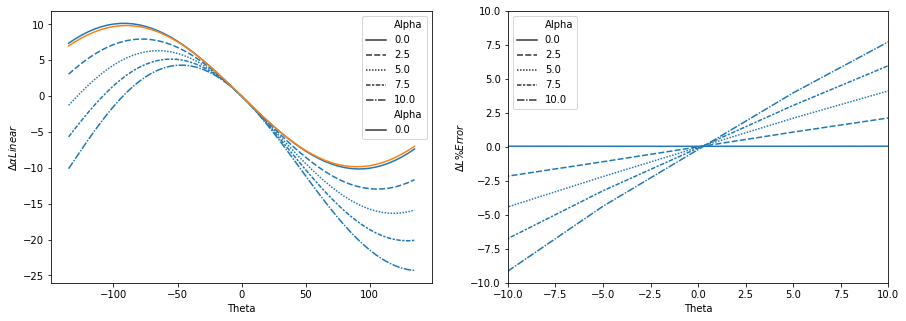

In [84]:
# add linear terms to the main pandas array
df[dAlphaLin] =np.rad2deg(np.arctan(np.sin(np.deg2rad(df['Theta']))*np.sin(np.deg2rad(df['Lambda']))))
df[dLiftLin] = np.deg2rad(df[dAlphaLin])
df[dAlphaErrorS] = df['DeltaAlpha_h']-df[dAlphaLin]
df[dLiftError] = (np.round(df['Delta Lift'],5)-df[dLiftLin])/np.round(df['Delta Lift'],5)*100

# get data to plot
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= dLiftError ,style='Alpha',ax=axes[1])

# plot the linear data ontop
dLin = d[d['Alpha']==0]
sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
axes[1].set(xlim=(-10,10),ylim=(-10,10))

Thats much better... I think the equation is wrong........

## Questions:

can i better fit the WTT trim data using this model over the linear one

Does this need to be considered for trim cases

